# Getting 2 pairs (image, mask) one for train one for test for all cell counts:

In [36]:
import os
import numpy as np
from PIL import Image
from glob import glob
from natsort import natsorted
import csv
import multiprocessing
from tqdm import tqdm
import re

# Function to extract the numeric part of the filename
def extract_number(filename):
    match = re.search(r'(\d+)', filename)
    return int(match.group()) if match else None

def compute_cell_count(msk_path):
    cell_count = len(np.unique(Image.open(msk_path))) - 1
    return msk_path, cell_count

dataset_wt_dir = '/media/micmac/New Volume/article/ScReports/github/microglia_video_microscopy_dataset/microglia_video_microscopy_dataset'


# Load image and mask paths
all_imgs_wt = natsorted(glob(os.path.join(dataset_wt_dir, 'WT', 'WT-*', 'scene_*', 'normalized_cell', '*.png')))
all_msks_wt = natsorted(glob(os.path.join(dataset_wt_dir, 'WT', 'WT-*', 'scene_*', 'labeled_cell', '*.png')))

# Filter images and masks where the name is between 0.png and 100.png
all_imgs_wt = [img for img in all_imgs_wt if 0 <= extract_number(os.path.basename(img)) <= 100]
all_msks_wt = [msk for msk in all_msks_wt if 0 <= extract_number(os.path.basename(msk)) <= 100]


# Use a pool of processes to compute cell counts in parallel
with multiprocessing.Pool() as pool:
    cell_count_results = list(tqdm(pool.imap(compute_cell_count, all_msks_wt), total=len(all_msks_wt), desc="Computing Cell Counts"))

# Map cell counts to (image, mask) path pairs
cell_count_map = {}
for msk_path, cell_count in cell_count_results:
    img_path = all_imgs_wt[all_msks_wt.index(msk_path)]
    if cell_count not in cell_count_map:
        cell_count_map[cell_count] = []
    cell_count_map[cell_count].append((img_path, msk_path))

# Flatten the cell_count_map into a list of tuples (cell_count, image_path, mask_path)
flattened_data = []
for cell_count, img_mask_pairs in cell_count_map.items():
    for img_path, msk_path in img_mask_pairs:
        flattened_data.append((cell_count, img_path, msk_path))

# Write the flattened data to a CSV file
csv_file = "cell_count_data.csv"
with open(csv_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Cell Count', 'Image Path', 'Mask Path'])
    for row in flattened_data:
        writer.writerow(row)
print(f"Data saved to {csv_file}")




Computing Cell Counts: 100%|██████████| 9191/9191 [01:01<00:00, 149.53it/s]


Data saved to cell_count_data.csv


In [4]:
import csv
import random
from tqdm import tqdm
import os

# Set random seed for reproducibility
random.seed(0)

# Function to read the CSV and create a cell count map
def read_cell_count_data(csv_file):
    cell_count_map = {}
    with open(csv_file, mode='r') as file:
        reader = csv.reader(file)
        next(reader)  # Skip the header row
        for row in reader:
            cell_count, img_path, msk_path = row
            if int(cell_count) not in cell_count_map:
                cell_count_map[int(cell_count)] = []
            cell_count_map[int(cell_count)].append((img_path, msk_path))
    return cell_count_map

# Read the data and create a cell count map
cell_count_map = read_cell_count_data("cell_count_data.csv")


# Sort the cell count map by cell count
cell_count_map = {k: cell_count_map[k] for k in sorted(cell_count_map)}


N = 3  # Number of pairs to keep for each cell count

used_scene_wt_combinations = set()  # Track used scene and WT combinations
selected_images_masks_counts = []

for cell_count, pairs in tqdm(cell_count_map.items(), desc="Selecting Images"):
    if cell_count <= 40:
        scene_group = {}
        for img_path, msk_path in pairs:
            parts = img_path.split(os.sep)
            scene = parts[-3]
            wt_id = parts[-4]
            scene_wt_key = (scene, wt_id)

            if scene_wt_key not in scene_group:
                scene_group[scene_wt_key] = []
            scene_group[scene_wt_key].append((img_path, msk_path))

        # Process each group and select up to N pairs per cell count
        pairs_selected = []
        for scene_wt_key in scene_group:
            if len(pairs_selected) >= N:
                break  # Stop if N pairs are already selected

            if scene_wt_key not in used_scene_wt_combinations:
                selected = random.choice(scene_group[scene_wt_key])
                pairs_selected.append((cell_count, *selected))
                used_scene_wt_combinations.add(scene_wt_key)

        # Check if N pairs are selected, if not, report
        if cell_count%2==1:
            print("Cell count is not pair")
            
        elif len(pairs_selected) < N:
            print(f"Not enough pairs available for cell count {cell_count}. Only {len(pairs_selected)} pairs were found.")
        
        else:
            selected_images_masks_counts.extend(pairs_selected[:N])


# Write results to CSV
csv_file = "selected_images_masks_counts.csv"
with open(csv_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Cell Count', 'Image Path', 'Mask Path'])
    for cell_count, img_path, msk_path in selected_images_masks_counts:
        writer.writerow([cell_count, img_path, msk_path])

print(f"Results saved to {csv_file}")


Selecting Images: 100%|██████████| 58/58 [00:00<00:00, 6723.13it/s]

Not enough pairs available for cell count 13. Only 1 pairs were found.
Not enough pairs available for cell count 15. Only 0 pairs were found.
Not enough pairs available for cell count 18. Only 2 pairs were found.
Not enough pairs available for cell count 42. Only 1 pairs were found.
Not enough pairs available for cell count 43. Only 1 pairs were found.
Not enough pairs available for cell count 44. Only 2 pairs were found.
Not enough pairs available for cell count 45. Only 1 pairs were found.
Not enough pairs available for cell count 46. Only 1 pairs were found.
Not enough pairs available for cell count 47. Only 0 pairs were found.
Not enough pairs available for cell count 48. Only 0 pairs were found.
Not enough pairs available for cell count 49. Only 0 pairs were found.
Not enough pairs available for cell count 50. Only 0 pairs were found.
Not enough pairs available for cell count 51. Only 0 pairs were found.
Not enough pairs available for cell count 52. Only 0 pairs were found.
Not en

# Sanity check:

In [38]:
import csv

# Function to extract scene and WT identifier from a file path
def extract_scene_wt_id(file_path):
    parts = file_path.split(os.sep)
    scene = parts[-3]
    wt_id = parts[-4]
    return scene, wt_id

# Read data from CSV
data = {}
with open('selected_images_masks_counts.csv', mode='r') as file:
    reader = csv.reader(file)
    next(reader)  # Skip the header
    for row in reader:
        cell_count, img_path, _ = row
        scene, wt_id = extract_scene_wt_id(img_path)
        if cell_count not in data:
            data[cell_count] = set()
        data[cell_count].add((scene, wt_id))

# Sanity check for repeated scene and WT combinations across different cell counts
repeated_combinations = set()
for cell_count, combinations in data.items():
    for other_count, other_combinations in data.items():
        if cell_count != other_count:
            common_combinations = combinations & other_combinations
            if common_combinations:
                repeated_combinations.update(common_combinations)

# Report results
if repeated_combinations:
    print("Found repeated scene and WT combinations across different cell counts:")
    for combination in repeated_combinations:
        print(combination)
else:
    print("Sanity check passed. No repeated scene and WT combinations found across different cell counts.")


Sanity check passed. No repeated scene and WT combinations found across different cell counts.


# Plotting the image mask per cell count:

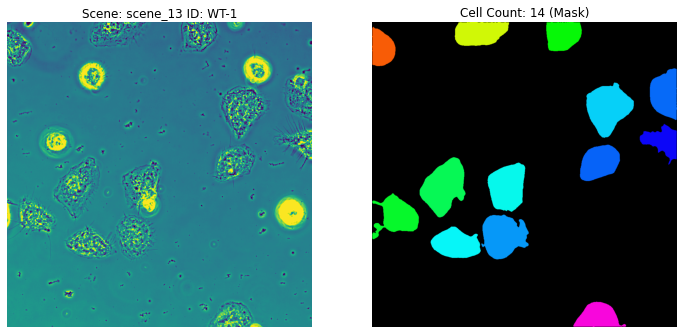

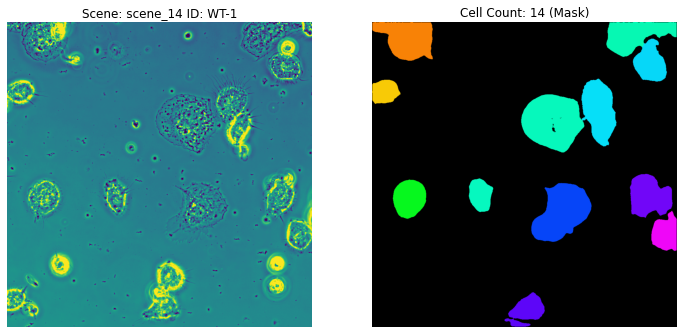

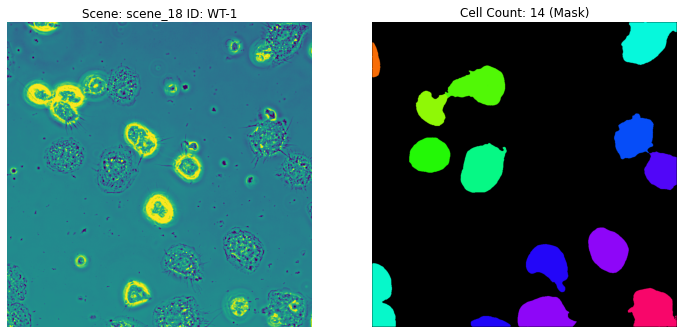

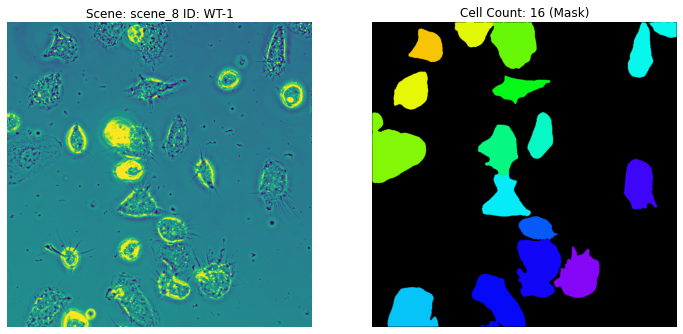

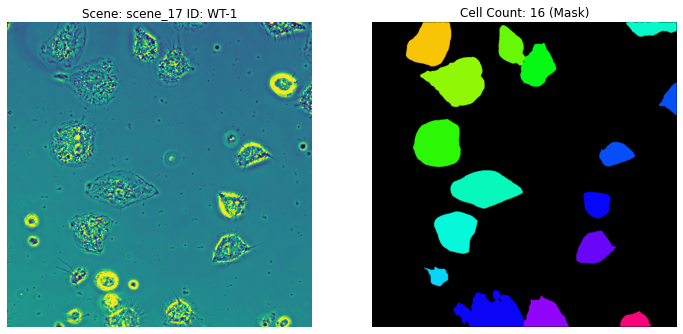

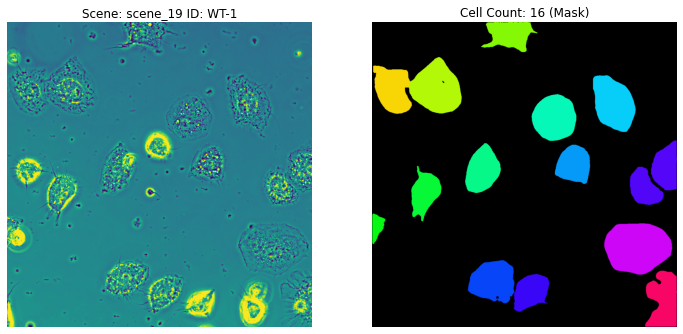

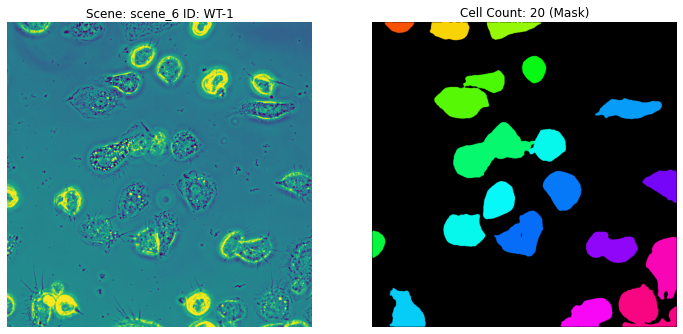

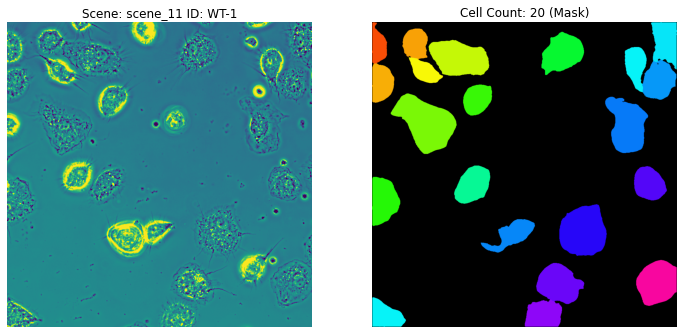

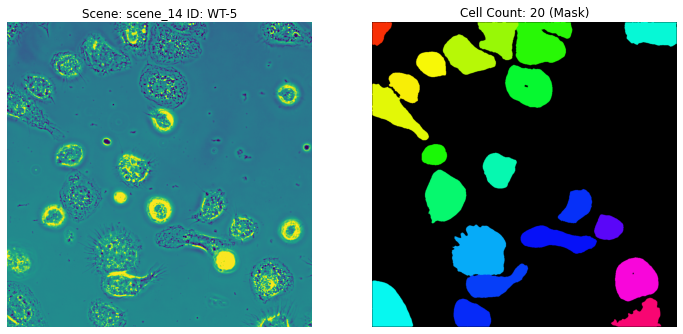

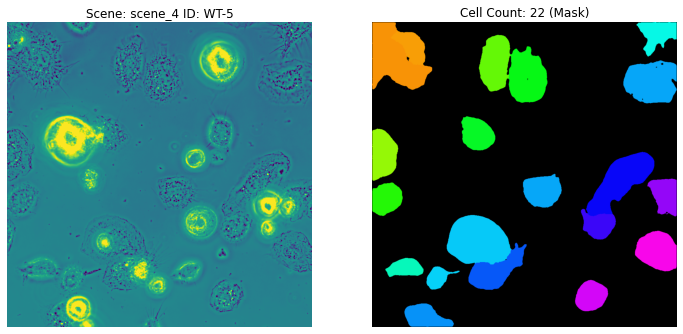

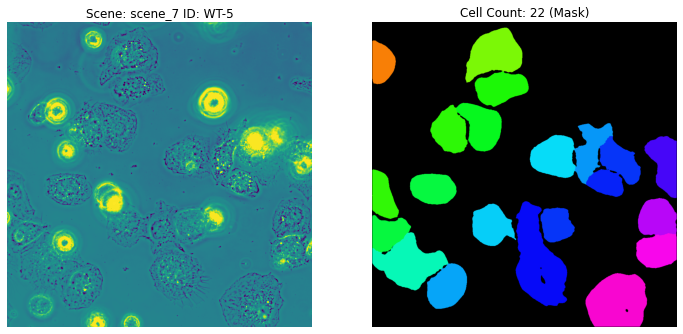

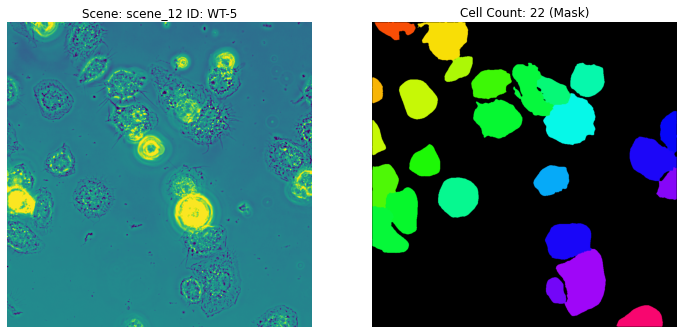

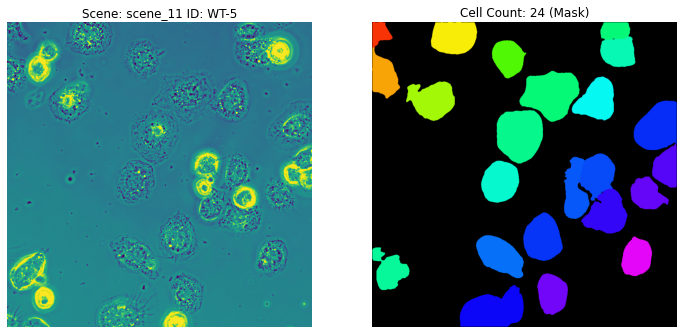

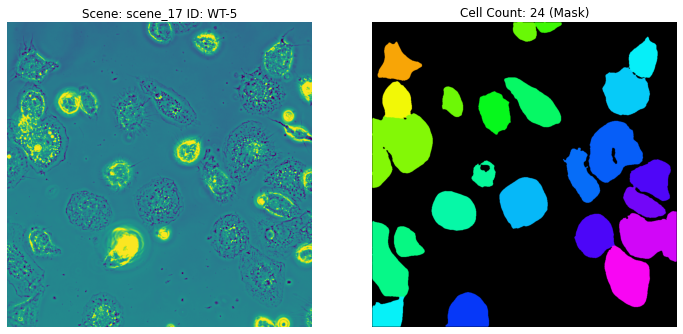

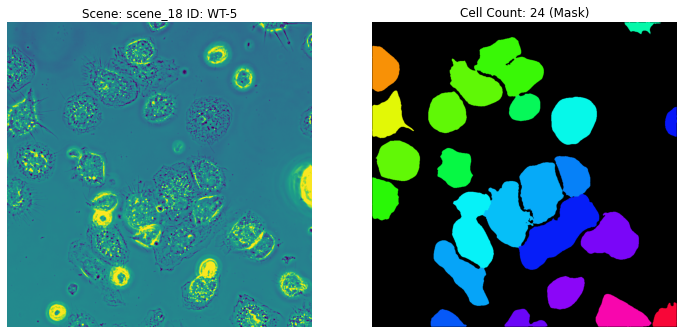

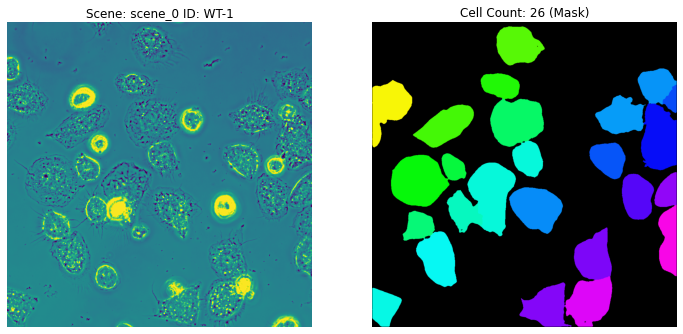

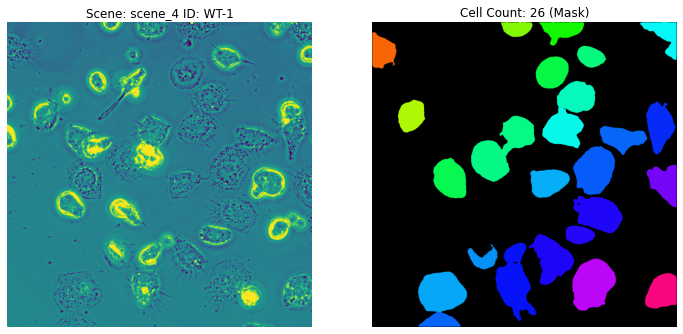

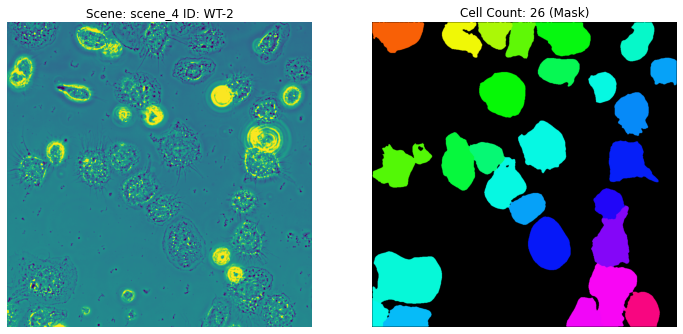

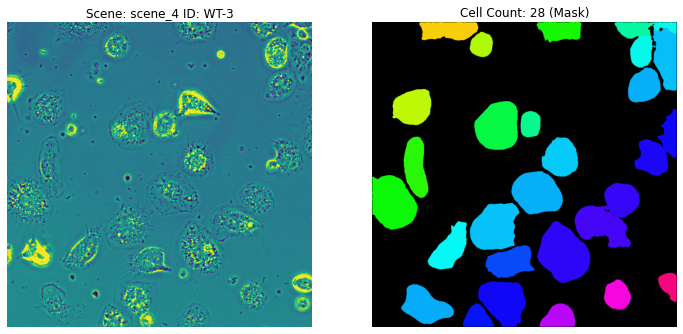

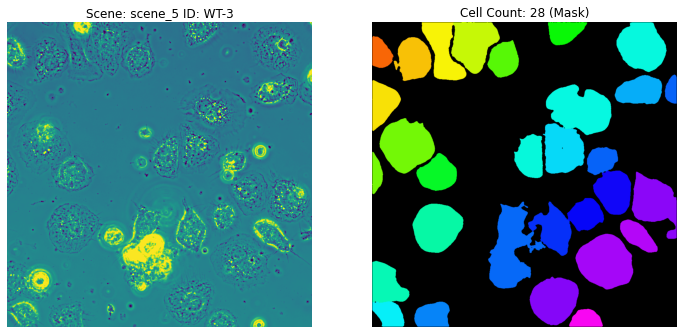

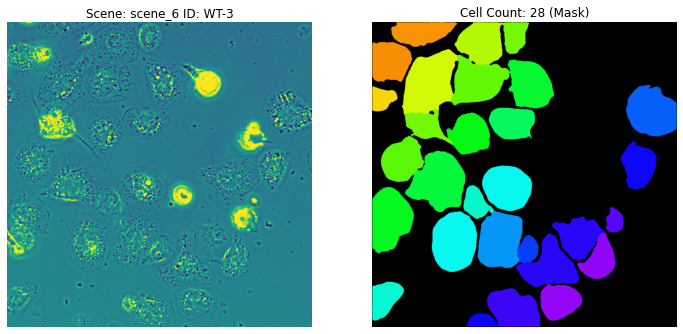

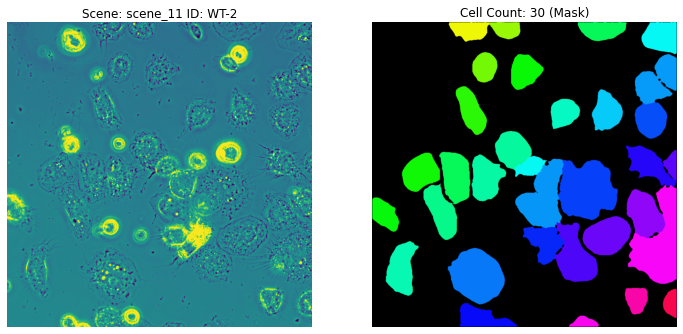

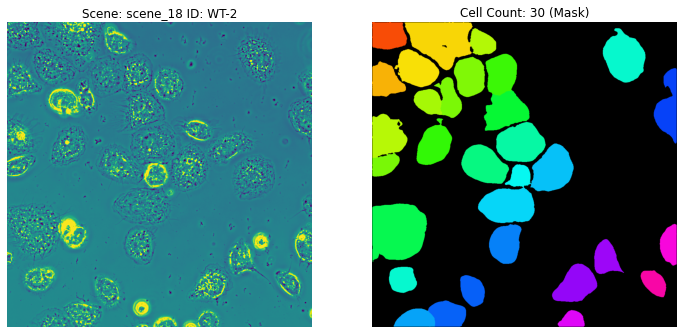

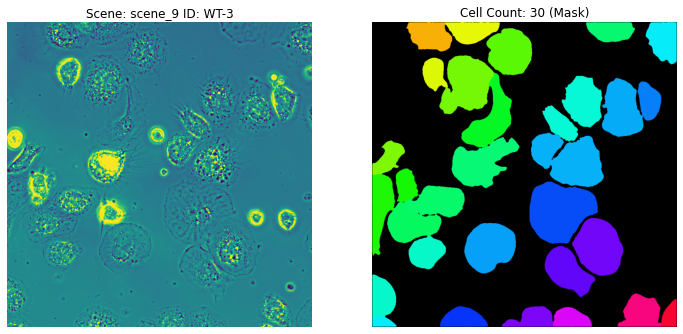

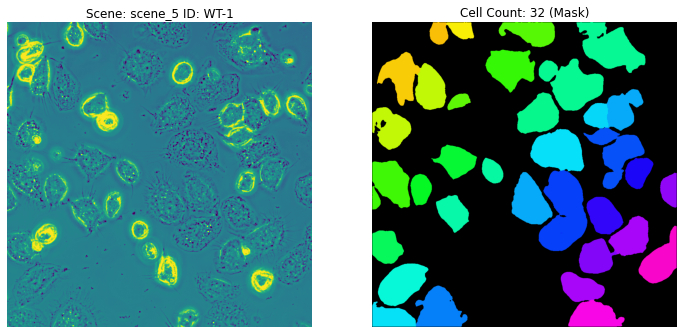

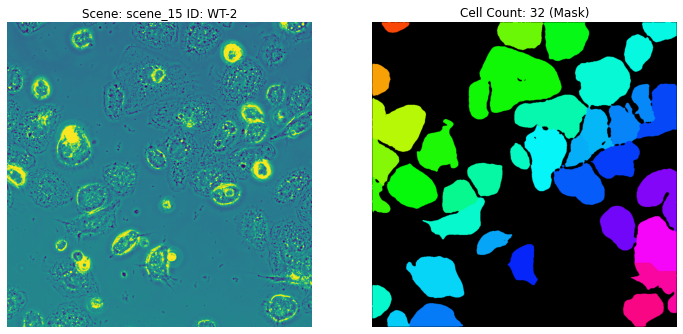

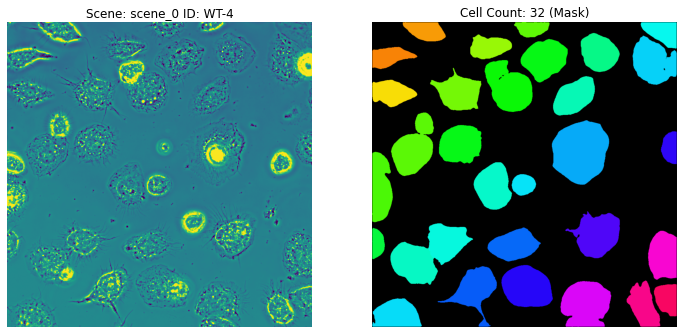

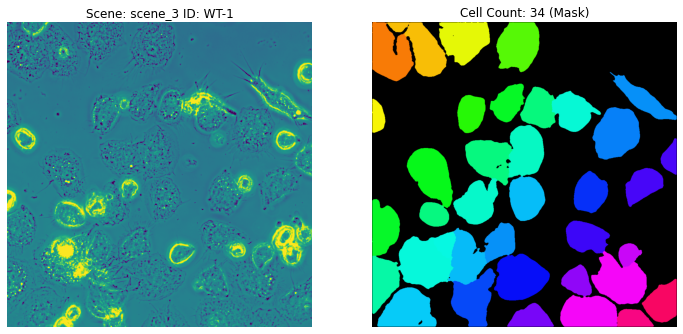

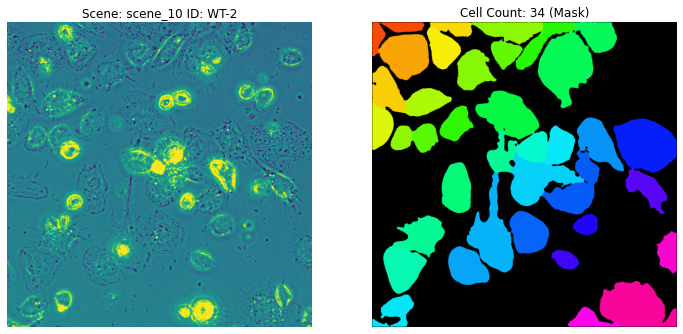

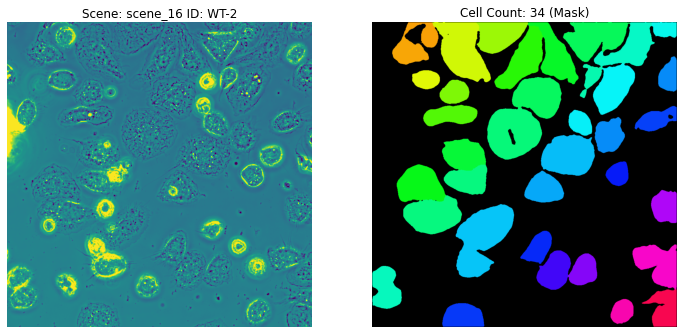

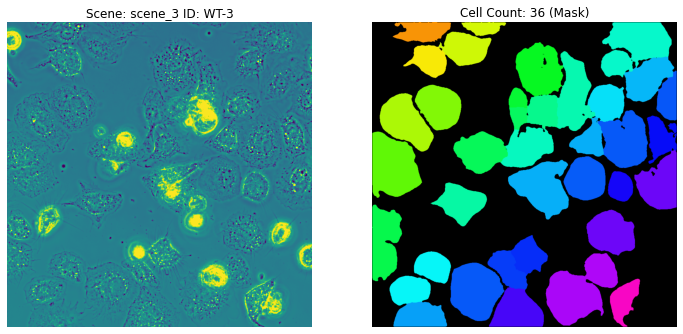

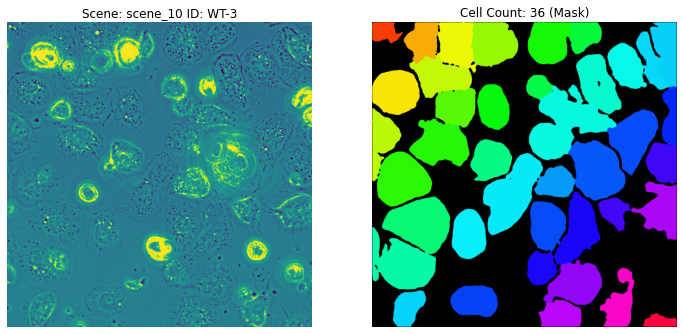

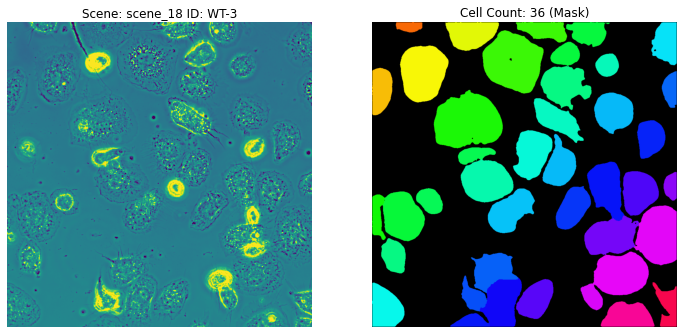

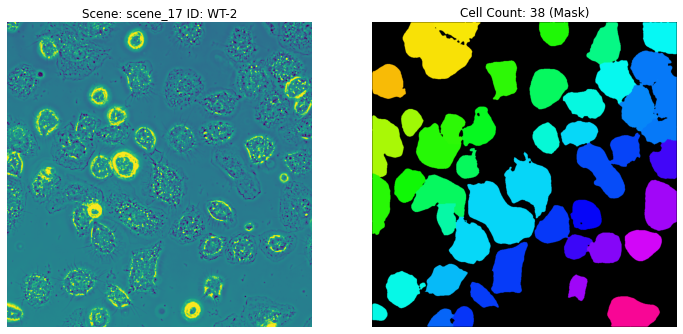

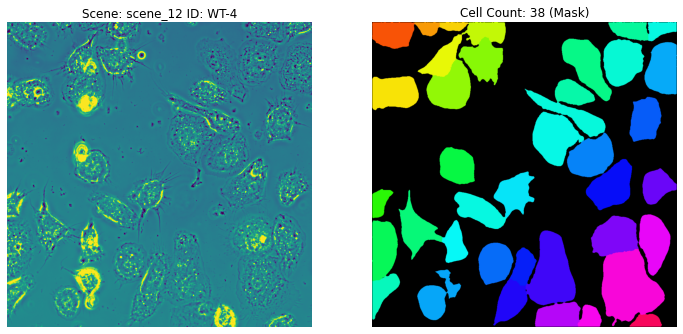

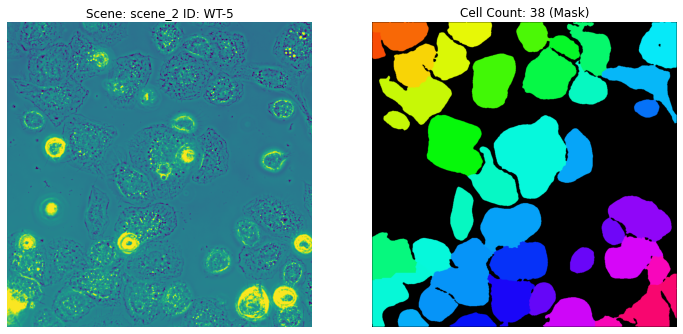

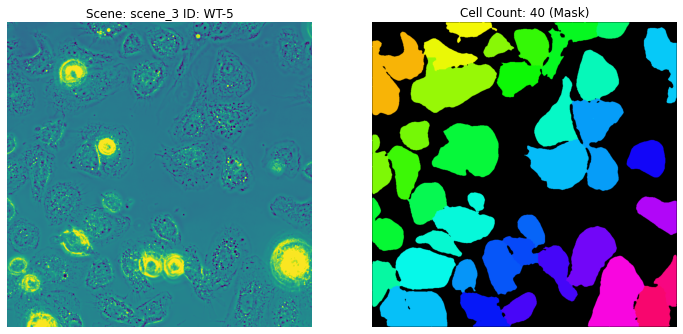

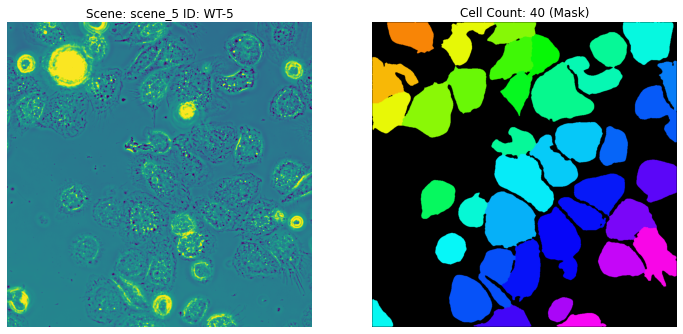

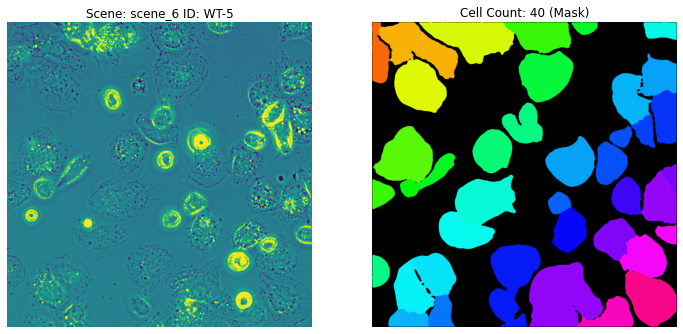

In [39]:
import csv
import matplotlib.pyplot as plt
from PIL import Image

# Read the data from the CSV file
data = []
with open('selected_images_masks_counts.csv', mode='r') as file:
    reader = csv.reader(file)
    next(reader)  # Skip the header row
    for row in reader:
        data.append(row)

# Sort the data by cell count
data.sort(key=lambda x: int(x[0]))

# Display each pair of images and masks
for cell_count, img_path, msk_path in data:
    # Load the images
    img = Image.open(img_path)
    msk = Image.open(msk_path)

    parts = img_path.split(os.sep)
    scene = parts[-3]
    wt_id = parts[-4]

    # Create subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    ax1.imshow(img)
    ax1.set_title(f'Scene: {scene} ID: {wt_id}')
    ax1.axis('off')

    ax2.imshow(msk)
    ax2.set_title(f'Cell Count: {cell_count} (Mask)')
    ax2.axis('off')

    # Display the plot
    plt.show()


# Generate cell count effect of Attunet(XAI) performance datasets:

In [3]:
import csv
import os
from PIL import Image
import numpy as np

def convert_rgb_to_label(msk_rgb):
    # Convert the mask image to a NumPy array
    msk_np = np.array(msk_rgb)

    # Flatten the 3D RGB array to a 2D array where each RGB pixel is a single number
    flat_rgb = np.dot(msk_np, [65536, 256, 1])  # This line combines RGB channels uniquely
    unique_colors, flat_labels = np.unique(flat_rgb, return_inverse=True)

    # Reshape the flat_labels array to the original image shape
    label_image = flat_labels.reshape(msk_np.shape[:2])

    # Convert labels to start from 1 instead of 0
    # label_image += 1

    return Image.fromarray(label_image.astype(np.uint16))


# Function to process and save images with rotations and flips
def process_and_save_images(image_path, mask_path, images_folder, masks_folder):
    angles = [0, 90, 180, 270]
    img = Image.open(image_path).resize((512, 512))
    mask = convert_rgb_to_label(Image.open(mask_path)).resize((512, 512), Image.NEAREST)
    img_name = os.path.splitext(os.path.basename(image_path))[0]
    mask_name = os.path.splitext(os.path.basename(mask_path))[0]

    for angle in angles:
        # Rotate images
        rotated_img = img.rotate(angle)
        rotated_mask = mask.rotate(angle)
        rotated_img.save(os.path.join(images_folder, f'{img_name}_rot{angle}.tif'))
        rotated_mask.save(os.path.join(masks_folder, f'{mask_name}_rot{angle}.tif'))

        # Flip images
        flipped_img = rotated_img.transpose(Image.FLIP_LEFT_RIGHT)
        flipped_mask = rotated_mask.transpose(Image.FLIP_LEFT_RIGHT)
        flipped_img.save(os.path.join(images_folder, f'{img_name}_rot{angle}_flipped.tif'))
        flipped_mask.save(os.path.join(masks_folder, f'{mask_name}_rot{angle}_flipped.tif'))

# Read and group the selected_images_masks_counts.csv data by cell count
def group_images_by_cell_count(csv_file):
    cell_count_group = {}
    with open(csv_file, mode='r') as file:
        reader = csv.reader(file)
        next(reader)  # Skip the header
        for row in reader:
            cell_count, img_path, msk_path = row
            if cell_count not in cell_count_group:
                cell_count_group[cell_count] = []
            cell_count_group[cell_count].append((img_path, msk_path))
    return cell_count_group

# Main process
cell_count_group = group_images_by_cell_count("selected_images_masks_counts.csv")
N = 3  # Number of pairs for each cell count

for cell_count, img_mask_pairs in cell_count_group.items():
    base_folder = os.path.join('datasets', 'cell_count_'+str(cell_count))

    # Directories for the datasets
    train_images_folder = os.path.join(base_folder, 'train/images')
    train_masks_folder = os.path.join(base_folder, 'train/masks')
    val_images_folder = os.path.join(base_folder, 'val/images')
    val_masks_folder = os.path.join(base_folder, 'val/masks')
    test_images_folder = os.path.join(base_folder, 'test/images')
    test_masks_folder = os.path.join(base_folder, 'test/masks')

    # Create the directories
    os.makedirs(train_images_folder, exist_ok=True)
    os.makedirs(train_masks_folder, exist_ok=True)
    os.makedirs(val_images_folder, exist_ok=True)
    os.makedirs(val_masks_folder, exist_ok=True)
    os.makedirs(test_images_folder, exist_ok=True)
    os.makedirs(test_masks_folder, exist_ok=True)

    # Process and save images for training and validation, copy for test
    if len(img_mask_pairs) >= N:
        # Train
        process_and_save_images(img_mask_pairs[0][0], img_mask_pairs[0][1], train_images_folder, train_masks_folder)
        # Validation
        process_and_save_images(img_mask_pairs[1][0], img_mask_pairs[1][1], val_images_folder, val_masks_folder)
        # Test

        img = Image.open(img_mask_pairs[2][0]).resize((512, 512)).save(os.path.join(test_images_folder, 'test_image.tif'))
        mask = convert_rgb_to_label(Image.open(img_mask_pairs[2][1])).resize((512, 512), Image.NEAREST).save(os.path.join(test_masks_folder, 'test_mask.tif'))
